In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import gym 
render=False
runs=1

In [ ]:
#| gui
render=True
runs=2000

## Cartpole

Cartpole is an Open AI gym environment for the inverted pendulum problem. The goal is to keep the pole balanced, by moving the cart left or right.

The environment provides observations (perceptions) for the state of the cart and pole.

0    -   Cart Position             
1    -   Cart Velocity             
2    -   Pole Angle                
3    -   Pole Angular Velocity 
        
It takes one value, of 0 or 1, for applying a force to the left or right, respectively.

The PCT solution is a four-level hierarchy for controlling the perceptions at goal values. Only one goal reference is manually set, the highest level which is the pole angle of 0. 

This example shows how a perceptual control hierarchy can be implemented with this library.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pct.hierarchy import PCTHierarchy
from pct.putils import FunctionsList
from pct.environments import CartPoleV1
from pct.functions import IndexedParameter
from pct.functions import Integration
from pct.functions import GreaterThan
from pct.functions import PassOn

Create a hierarchy of 4 levels each with one node.

In [ ]:
cartpole_hierarchy = PCTHierarchy(levels=4, cols=1, name="cartpoleh", build=False)
namespace=cartpole_hierarchy.namespace
cartpole_hierarchy.get_node(0, 0).name = 'cart_velocity_node'
cartpole_hierarchy.get_node(1, 0).name = 'cart_position_node'
cartpole_hierarchy.get_node(2, 0).name = 'pole_velocity_node'
cartpole_hierarchy.get_node(3, 0).name = 'pole_angle_node'
#FunctionsList.getInstance().report()
#cartpole_hierarchy.summary(build=True)

Create the Cartpole gym environment function. This will apply the "action" output from the hierarchy and provide the new observations.

In [ ]:
cartpole = CartPoleV1(name="CartPole-v1", render=render, namespace=namespace, seed=1)

Create functions for each of the observation parameters of the Cartpole environment. Insert them into the hierarchy at the desired places.

In [ ]:
cartpole_hierarchy.insert_function(level=0, col=0, collection="perception", function=IndexedParameter(index=1, name="cart_velocity", links=[cartpole], namespace=namespace))
cartpole_hierarchy.insert_function(level=1, col=0, collection="perception", function=IndexedParameter(index=0, name="cart_position", links=[cartpole], namespace=namespace))
cartpole_hierarchy.insert_function(level=2, col=0, collection="perception", function=IndexedParameter(index=3, name="pole_velocity", links=[cartpole], namespace=namespace))
cartpole_hierarchy.insert_function(level=3, col=0, collection="perception", function=IndexedParameter(index=2, name="pole_angle", links=[cartpole], namespace=namespace))

Link the references to the outputs of the level up.

In [ ]:
cartpole_hierarchy.insert_function(level=0, col=0, collection="reference", function=PassOn(name="cart_velocity_reference", links=['proportional1'], namespace=namespace))
cartpole_hierarchy.insert_function(level=1, col=0, collection="reference", function=PassOn(name="cart_position_reference", links=['proportional2'], namespace=namespace))
cartpole_hierarchy.insert_function(level=2, col=0, collection="reference", function=PassOn(name="pole_velocity_reference", links=['proportional3'], namespace=namespace))

Set the highest level reference.

In [ ]:
top = cartpole_hierarchy.get_function(level=3, col=0, collection="reference")
top.set_name("pole_angle_reference")
top.set_value(0)

Link the output of the hierarchy back to the Cartpole environment.

In [ ]:
cartpole_hierarchy.summary(build=True)

**************************
cartpoleh PCTHierarchy [1, 1, 1, 1] b0eb903c-cfdc-11ed-a961-00155d10805a
--------------------------
PRE: None
Level 0 Cols 1
cart_velocity_node PCTNode
----------------------------
REF: cart_velocity_reference PassOn | 0 | links  proportional1 
PER: cart_velocity IndexedParameter | index 1 | 0 | links  CartPole-v1 
COM: subtract Subtract | 0 | links  cart_velocity_reference cart_velocity 
OUT: proportional Proportional | gain 1 | 0 | links  subtract 
----------------------------
Level 1 Cols 1
cart_position_node PCTNode
----------------------------
REF: cart_position_reference PassOn | 0 | links  proportional2 
PER: cart_position IndexedParameter | index 0 | 0 | links  CartPole-v1 
COM: subtract1 Subtract | 0 | links  cart_position_reference cart_position 
OUT: proportional1 Proportional | gain 1 | 0 | links  subtract1 
----------------------------
Level 2 Cols 1
pole_velocity_node PCTNode
----------------------------
REF: pole_velocity_reference PassOn | 0 |

In [ ]:
cartpole_hierarchy.insert_function(level=0, col=0, collection="output", function=Integration(gain=-0.05, slow=4, name="force", links='subtract', namespace=namespace))

Set the names and gains of the output functions. This also shows another way of getting a function, by name.

In [ ]:
FunctionsList.getInstance().get_function(namespace=namespace, name="proportional3").set_name("pole_angle_output")
FunctionsList.getInstance().get_function(namespace=namespace, name="pole_angle_output").set_property('gain', 3.5)

FunctionsList.getInstance().get_function(namespace=namespace, name="proportional2").set_name("pole_velocity_output")
FunctionsList.getInstance().get_function(namespace=namespace, name="pole_velocity_output").set_property('gain', 0.5)

FunctionsList.getInstance().get_function(namespace=namespace, name="proportional1").set_name("cart_position_output")
FunctionsList.getInstance().get_function(namespace=namespace, name="cart_position_output").set_property('gain', 2)

Add a post function to convert the output to 1 or 0 as required by the Cartpole environment. 

In [ ]:
greaterthan = GreaterThan(threshold=0, upper=1, lower=0, links='force', namespace=namespace)
cartpole_hierarchy.add_postprocessor(greaterthan)

Add the cartpole function as one that is executed before the actual hierarchy.

In [ ]:
cartpole_hierarchy.add_preprocessor(cartpole)

Set the output of the hierachy as the action input to the Cartpole environment. 

In [ ]:
#link = cartpole_hierarchy.get_output_function()
cartpole.add_link(greaterthan)

Sit back and observe the brilliance of your efforts. 

In [ ]:
cartpole_hierarchy.set_order("Down")

In [ ]:
cartpole_hierarchy.summary()

**************************
cartpoleh PCTHierarchy [1, 1, 1, 1] b0eb903c-cfdc-11ed-a961-00155d10805a
--------------------------
PRE: CartPole-v1 CartPoleV1 | 0 | links  greaterthan 
Level 3 Cols 1
pole_angle_node PCTNode
----------------------------
REF: pole_angle_reference Constant | 0 
PER: pole_angle IndexedParameter | index 2 | 0 | links  CartPole-v1 
COM: subtract3 Subtract | 0 | links  pole_angle_reference pole_angle 
OUT: pole_angle_output Proportional | gain 3.5 | 0 | links  subtract3 
----------------------------
Level 2 Cols 1
pole_velocity_node PCTNode
----------------------------
REF: pole_velocity_reference PassOn | 0 | links  pole_angle_output 
PER: pole_velocity IndexedParameter | index 3 | 0 | links  CartPole-v1 
COM: subtract2 Subtract | 0 | links  pole_velocity_reference pole_velocity 
OUT: pole_velocity_output Proportional | gain 0.5 | 0 | links  subtract2 
----------------------------
Level 1 Cols 1
cart_position_node PCTNode
----------------------------
REF: cart_p

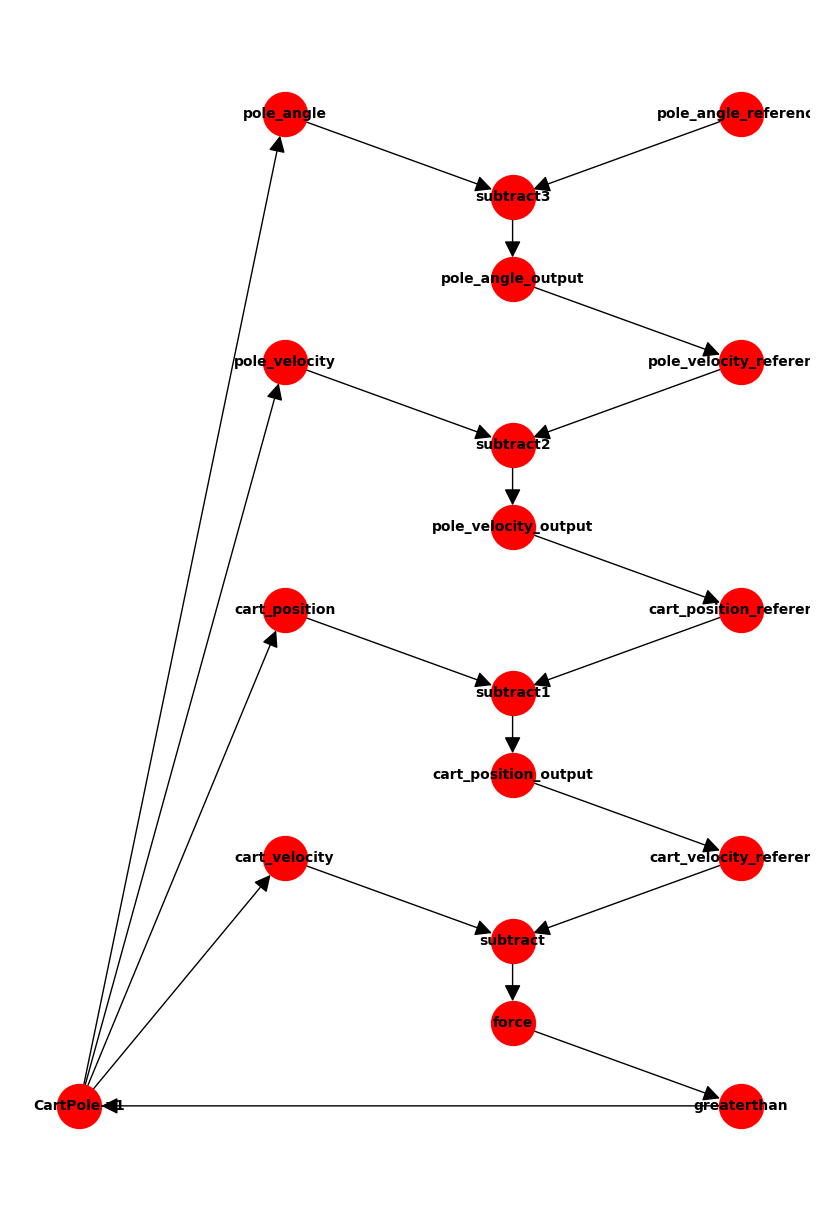

In [ ]:
#| gui
cartpole_hierarchy.draw(font_size=10, figsize=(8,12), move={'CartPole-v1': [-0.075, 0]}, node_size=1000, node_color='red')

In [ ]:
cartpole_hierarchy.save("cartpole.json")

TypeError: 'int' object is not iterable

In [ ]:
import networkx as nx
gr = cartpole_hierarchy.graph()
print(nx.info(gr))
print(gr.nodes())

Run the hierarchy for 500 steps.

In [ ]:
cartpole_hierarchy.run(1,verbose=False)

In [ ]:
cartpole_hierarchy.run(runs,verbose=False)

In [ ]:
cartpole.close()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()